In [1]:
train_path = 'data/car_brand_logos/Train/'
test_path = 'data/car_brand_logos/Test/'

SAVE_PATH = 'trained/auto_brand_25e_full.pth'
SAVE_PATH2 = 'trained/auto_brand_25e_full_best.pth'
RUNS_PATH = 'runs/car_brands_full'

### Imports

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, ToPILImage
from torchvision.transforms.functional import to_grayscale, to_tensor, rotate, hflip
import matplotlib.pyplot as plt

import os
import random
import pandas as pd
from torchvision.io import read_image

from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from sklearn.metrics import classification_report, confusion_matrix

from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import seaborn as sn
import numpy as np

import io
from PIL import Image

### Useful functions to retrive the data

In [3]:
# create a annotations_file.csv (index -> img (name), label (int))

def getLabelList(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    index = 0
    
    for d in only_dirs:
        new_path = path + d
        label = only_dirs.index(d)
        # print(len(os.listdir(new_path)))
        for img in [ name for name in os.listdir(new_path) ]:
            ret[index] = [img, label]
            index += 1
    
    return pd.Series(ret)

In [4]:
# create the pool of images (with a series that contains all the images, more deeply: index -> abs path, label (int), class (string))

def getImgPool(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    index = 0
    
    for d in only_dirs:
        new_path = path + d
        label = only_dirs.index(d)
        # cnt = 0
        for img in [ name for name in os.listdir(new_path) ]:
            abs_path = new_path + '/' + img
            ret[index] = [abs_path, label, d]
            index += 1
            # cnt += 1
        # print(f"Label: {d} - Number: {cnt}")
    
    return pd.Series(ret)

### Defining the custom dataset (structure that holds the data)

In [5]:
# wrong_images_path = []
import traceback

class CustomImageDataset(Dataset):
    def __init__(self, path_labels, transform=None, target_transform=None, use_aug=True):
        self.img_labels = getLabelList(path_labels)
        self.images = getImgPool(path_labels)
        self.transform = transform
        self.target_transform = target_transform
        self.use_aug = use_aug

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        try: 
            image = read_image(self.images.loc[idx][0])
        except Exception:
            print('Found error at {} {}'.format(self.images.loc[idx][0], idx))
        #     wrong_images_path.append(self.images.loc[img_name][0])
            #return torch.zeros((1, 600, 600)), -1
        # image = read_image(self.images.loc[img_name][0])
        if image.shape[0] >= 3: #apply grayscale to colored img
            image = to_tensor(to_grayscale(ToPILImage()(image), num_output_channels=1))
        else: #we have a greyscaled image, move it into tensor 
            image = to_tensor(ToPILImage()(image))
            
        image = Resize((300, 300))(image)
        #data augmentation
        if self.use_aug:
            fr = random.choices([0,1],[0.2,0.8])[0]
            if fr == 1: 
                angle = torch.randint(40, size=(1,)).item() - 20
                #print (f'Rotate: {angle}')
                image = rotate(image, angle)

            fr = random.choices([0,1],[0.5,0.5])[0]
            if fr == 1: 
                image = hflip(image)
        
        #image = image.permute(1,2,0) #made to be shown on matplotlib
        label = self.img_labels.loc[idx][1]
        #if self.transform:
        #    image = self.transform(image)
        #if self.target_transform:
        #    label = self.target_transform(label)
        
        return image, label

### Creating the 2 dataset and testing

In [6]:
# train_data = CustomImageDataset(path_labels=train_path, transform=ToTensor(), num_of_channels=3)
# test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), num_of_channels=3)

train_data = CustomImageDataset(path_labels=train_path, transform=ToTensor(), target_transform=ToTensor())

test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), target_transform=ToTensor(), use_aug=False)

print (f'train dataset: {train_data.__len__()}')
print (f'test dataset: {test_data.__len__()}')

train dataset: 2513
test dataset: 400


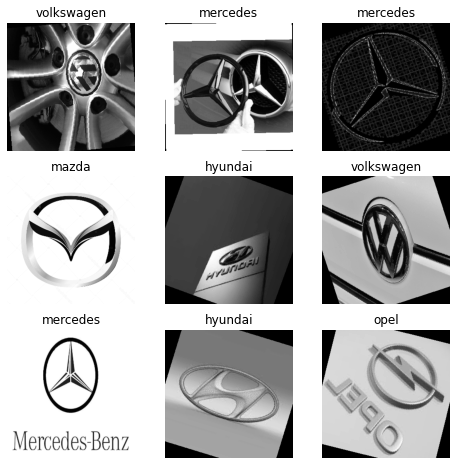

In [7]:
#testing dataset if images are loaded

only_dirs = [ name for name in os.listdir(train_path) if 
                 os.path.isdir(os.path.join(train_path, name)) ]

diz = {}
nocl=0 #num of classes
for d in only_dirs:
    diz[nocl] = d
    nocl+=1

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item() 
    img, label = train_data[sample_idx]
    # print (img.shape, img.dtype, label)
    figure.add_subplot(rows, cols, i)
    plt.title(diz[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
    # plt.imshow(img.squeeze())
plt.show()

### creating dataloader (who iterate on data, create batches and shuffles it)


Feature batch shape: torch.Size([8, 1, 300, 300])
Labels batch shape: torch.Size([8])


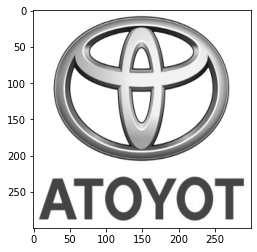

Label: toyota


In [8]:
train_dl = DataLoader(train_data, batch_size=8, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_data, batch_size=8, shuffle=True)

#dataloader test (ask a batch or a sample)
images, labels = next(iter(train_dl)) #picking a batch
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")
img = images[0].permute(1,2,0) #picking the first img and label of the batch
label = labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f"Label: {diz[label.item()]}")

In [9]:
labels

tensor([6, 7, 7, 6, 2, 0, 6, 5])

### Defining the neural network

In [10]:
print("GPU compute available: ", torch.cuda.is_available())


GPU compute available:  True


In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [12]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        #conv1: 1 input image channel (image channel, 1 gray, 3 rgb), 6 output channels (depth [K]), 5x5 square convolution kernel, DEFAULT: stride = 1,1, padding = 0
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)        
        self.fc_layer1 = nn.Linear(16 * 72 * 72, 120)        
        self.fc_layer2 = nn.Linear(120, 84)
        self.fc_layer3 = nn.Linear(84, nocl) # nocl is the num of classes

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.pool(F.relu(self.conv1(x)))
        #print ('conv1', x.shape)
        # If the size is a square, you can specify with a single number
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        #print ('flatten', x.shape)
        x = F.relu(self.fc_layer1(x))
        x = F.relu(self.fc_layer2(x))
        x = self.fc_layer3(x)
        return x

### Confusion matrix

In [13]:
def createConfusionMatrix(loader, netw):
    y_pred = [] # save predction
    y_true = [] # save ground truth

    # iterate over data
    for inputs, labels in loader:
        output = netw(inputs.to(device))  # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)  # save prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)  # save ground truth

    # constant for classes
    classes = diz.values()

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index=[i for i in classes],
                         columns=[i for i in classes])
    plt.figure(figsize=(7, 7), dpi=125)
    sn.heatmap(df_cm, annot=True)
    
    buf = io.BytesIO()
    plt.savefig(buf, format='jpeg')
    buf.seek(0)
    im = Image.open(buf)
    im = ToTensor()(im)
    return im

### Testing the network on test set

In [23]:
loaded = Net()
# loaded.load_state_dict(torch.load("trained/auto_brand_no_flip_16e.pth"))
loaded.load_state_dict(torch.load(SAVE_PATH2))

<All keys matched successfully>

In [24]:
loaded.to(device)
loaded.eval()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc_layer1): Linear(in_features=82944, out_features=120, bias=True)
  (fc_layer2): Linear(in_features=120, out_features=84, bias=True)
  (fc_layer3): Linear(in_features=84, out_features=8, bias=True)
)

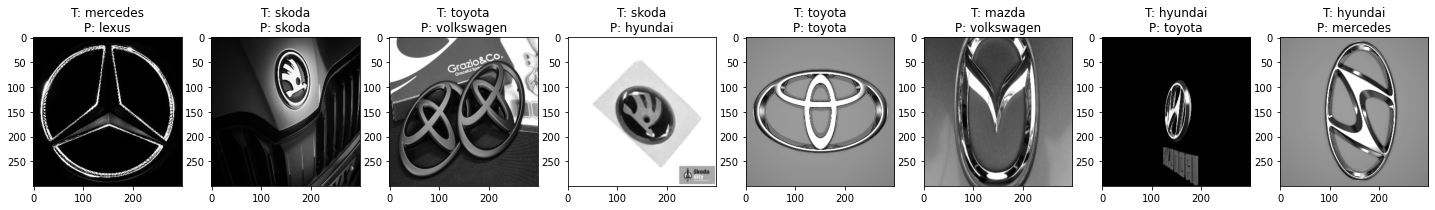

In [25]:
images, labels = next(iter(test_dl)) #picking a batch

n_imgs = len(images)
img = images.to(device)
label = labels.to(device)

preds = loaded(img)
_, best_pred = torch.max(preds.data, 1)

fig, axs = plt.subplots(figsize=(25,4), nrows=1, ncols=n_imgs)

for i in range(n_imgs):
    axs[i].imshow(img[i].permute(1,2,0).cpu(), cmap='gray')
    axs[i].set_title('T: {}\nP: {}'.format(diz[label[i].item()], diz[best_pred[i].item()]))

### Tensorboard setup

start tensorboard: `tensorboard --logdir=Users\eliad\Tesi\ProgettoTesi\runs\car_brands_1`

In [26]:
writer = SummaryWriter(RUNS_PATH)

In [19]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
class_probs = []
class_label = []
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        output = loaded(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(diz[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(diz.values())):
   add_pr_curve_tensorboard(i, test_probs, test_label)

In [27]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in diz}
total_pred = {classname: 0 for classname in diz}

y_true = []
y_pred = []

# again no gradients needed
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = loaded(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[label.item()] += 1
            total_pred[label.item()] += 1
            y_true.append(label.cpu())
            y_pred.append(prediction.cpu())

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {diz[classname]} is {accuracy:.1f} %')

Accuracy for class: hyundai is 48.0 %
Accuracy for class: lexus is 42.0 %
Accuracy for class: mazda is 74.0 %
Accuracy for class: mercedes is 62.0 %
Accuracy for class: opel is 44.0 %
Accuracy for class: skoda is 46.0 %
Accuracy for class: toyota is 44.0 %
Accuracy for class: volkswagen is 60.0 %


In [28]:
#stampa report classificazioni
print(classification_report(y_true, y_pred, target_names=diz.values()))

              precision    recall  f1-score   support

     hyundai       0.44      0.48      0.46        50
       lexus       0.49      0.42      0.45        50
       mazda       0.82      0.74      0.78        50
    mercedes       0.66      0.62      0.64        50
        opel       0.69      0.44      0.54        50
       skoda       0.45      0.46      0.46        50
      toyota       0.32      0.44      0.37        50
  volkswagen       0.50      0.60      0.55        50

    accuracy                           0.53       400
   macro avg       0.55      0.52      0.53       400
weighted avg       0.55      0.53      0.53       400



In [31]:
# fig, axs = plt.subplots(figsize=(20,12), nrows=1, ncols=2)
# axs[0].imshow(createConfusionMatrix(test_dl, loaded).permute(1,2,0))
# axs[0].set_title('Trained Net')
# axs[1].imshow(createConfusionMatrix(test_dl, loaded).permute(1,2,0))
# axs[1].set_title('Loaded Net')

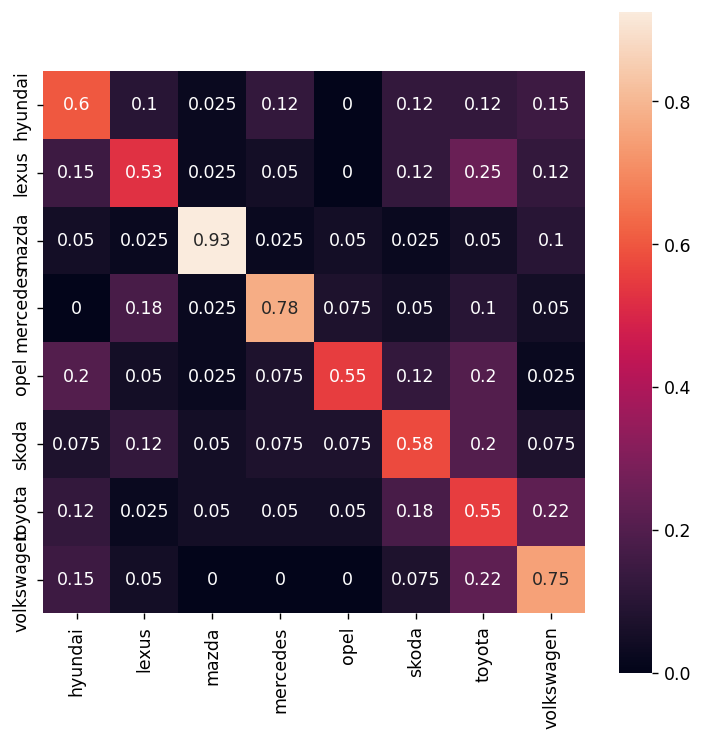

In [30]:
plt.imshow(createConfusionMatrix(test_dl, loaded).permute(1,2,0))